# Project -  Predicting Bike Rentals

## Introduction

### Preliminary

This Notebook is the conclusion of the **Decision Trees ** course from [dataquest.io](dataquest.io). It is a guided project whose aim is to use all the techniques and skills learnt during the course. Nevertheless we are dealing with real-world data.  
We will be working here with data from communal bike stations of Washington DC. The District collects detailed data on the number of bicycles people rent by the hour and day. The Dataset can be downloaded [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).


#### Blockquotes usage
> I am sometimes using blockquotes as this one, meaning that for the rest of the project I am quoting some elements given by dataquest. For the sake of simplicity and clarity, I estimated that they did not need any reformulation and were immediately usable and convenient for me and the reader.

### Context



The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day.

Here are the descriptions for the relevant columns:

    instant - A unique sequential ID number for each row
    dteday - The date of the rentals
    season - The season in which the rentals occurred
    yr - The year the rentals occurred
    mnth - The month the rentals occurred
    hr - The hour the rentals occurred
    holiday - Whether or not the day was a holiday
    weekday - The day of the week (as a number, 0 to 7)
    workingday - Whether or not the day was a working day
    weathersit - The weather (as a categorical variable)
    temp - The temperature, on a 0-1 scale
    atemp - The adjusted temperature
    hum - The humidity, on a 0-1 scale
    windspeed - The wind speed, on a 0-1 scale
    casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
    registered - The number of registered riders (people who had already signed up)
    cnt - The total number of bike rentals (casual + registered)

#### Objective
We'll try to predict the total number of bikes people rented in a given hour. We'll predict the `cnt` column using all of the other columns, except for casual and registered. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

## Reading the Data

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


Let's plot an histogramm of the `cnt` column to have a look to its distribution.
As shown below most of the values are located between 0 and 200.

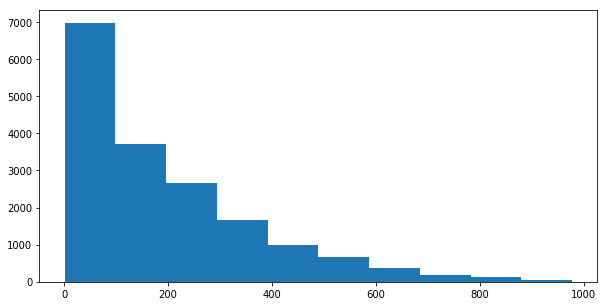

In [45]:
bike_rentals["cnt"].hist(bins=10,grid=False,figsize=(10,5))
plt.show()


In [46]:
bike_rentals.corr()["cnt"].sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

After calculating the correalation between the `cnt` column and the other columns of the data set, we can see that:
- obviously registred and casual highly correlate with cnt as, cnt = casual + registred. By the way we won't use these two columns when trying to predict the cnt target later.
- temp (the temperature), atemp (the adjusted temperature) and hr have a strong correlation with cnt with coefficients around 0.4
- hum (the humidity) is strongly negatively correlated with cnt. (coefficient = -0.32)

### Calculating Features

> It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

> For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [47]:
def assign_label(x):
    if 6<=x<12:
        #morning
        return 1
    elif 12<=x<18:
        #afternoon
        return 2
    elif 18<=x<24:
        #evening
        return 3
        #night
    else:
        return 4

In [48]:
bike_rentals["time_label"]=bike_rentals["hr"].apply(assign_label)

### Choosing a metric error

We will use the Mean Absolute Error (abreviated for the rest of the project *MEA*) to evaluate further the performances of our different machine learning algorithms. 
> *MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight. From an interpretation standpoint, MAE is better than RMSE (Root Mean Squared Error), but the latter has the benefit of penalizing large errors more so can be more appropriate in some cases* 
(see [here](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d))

In [49]:
from sklearn.metrics import mean_absolute_error

### Splitting the Data into Train and Test sets

We will split our Data set into two sub data sets.
- the train data set, containing 80% of the original data set, and which will be used to train our models
- the test data set, containing the remaining 20% of the original data set. It will be used to test our previously trained model.

To select randomly 80% of the rows of the original data set, we will use the `pandas.Dataframe.sample()` method;

In [50]:
train = bike_rentals.sample(frac=0.8)

In [51]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Creating maching learning models
### Applying a linear regression

In [52]:
bike_rentals.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'time_label'],
      dtype='object')

Before training and testing our model we have to decide which predictors (also called features) we are going to use.
- First we will remove the `instant,dteday,year` columns as they do not bring useful information to train the model
- the `casual, registred` columns have to be excluded from the predictors as `cnt` = `casual + registred`
- the `atemp` column will be left out, as it is almost perfectly correlated with the `temp` column
- the `hour` column will be dropped as we created another feature called `time_label` so that hours are related together
- the `mnth` column and the `weekday` : not useful to build a regression model

In [53]:
features = bike_rentals.columns.drop(["instant","dteday","yr","casual","registered","atemp","hr","weekday","mnth","cnt"]).tolist()

target = "cnt"

In [54]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error

In [55]:
lr = linear_model.LinearRegression() 
fit = lr.fit(train[features],train["cnt"]) 
test_predictions = lr.predict(test[features])
test_mea = mean_absolute_error(test["cnt"],test_predictions)
print(test_mea)

105.261433554


We got a MEA = 105 which is quite a large error.

In [57]:
features = bike_rentals.columns.drop(["cnt","instant","dteday","yr","casual","registered","atemp","hr",\
                                      "mnth","weekday","holiday","workingday"]).tolist()
lr = linear_model.LinearRegression() 
fit = lr.fit(train[features],train["cnt"]) 
test_predictions = lr.predict(test[features])
test_mea = mean_absolute_error(test["cnt"],test_predictions)
print(test_mea)


105.252880223


When we try now to drop two other predictors : `holiday` and `workingday`  so we are not improving the model.

### Applying Decision Trees

We are now going to try another machine learning algorithm : *** Decision Trees***. It will allows us then to choose between the best of the two algorithms depending on the error we get for the decision trees.

> Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

#### Decision Trees (no tweaks)

In [58]:
features = bike_rentals.columns.drop(["instant","dteday","yr","casual","registered","atemp","hr","weekday","mnth","cnt"]).tolist()

target = "cnt"

In [59]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=1)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

103.228720752


***Conclusion ***:

When training and testing a Regressor Decision Tree without any tweaks we got a MEA_tree = **103**  < MEA_lr = ** 105 **

So overall the Decision Tree model is slightly better than the Linear Regression.


#### Decision Trees ( tweaking some parameters) 

Let's try now to adjust some parameters of the `DecisionTree` class to see if it changes the error

In [16]:
features = bike_rentals.columns.drop(["instant","dteday","yr","casual","registered","atemp","hr","weekday","mnth","cnt"]).tolist()

target = "cnt"

##### min_samples_leaf

In [17]:
tree = DecisionTreeRegressor(random_state=1,min_samples_leaf=1)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

102.969979862


In [18]:
tree = DecisionTreeRegressor(random_state=1,min_samples_leaf=10)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

85.5430559188


In [19]:
tree = DecisionTreeRegressor(random_state=1,min_samples_leaf=30)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

84.3185071616


**Conclusion**:
As we rise the `min_samples_leaf` parameter, ther error is also decreasing. We get a MEA = **84.34**

##### max_depth

In [20]:
tree = DecisionTreeRegressor(random_state=1,max_depth = 5)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

90.3419269528


In [21]:
tree = DecisionTreeRegressor(random_state=1,max_depth = 10)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

84.2715115615


In [22]:
tree = DecisionTreeRegressor(random_state=1,max_depth = 100)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

102.969979862


In [23]:
tree = DecisionTreeRegressor(random_state=1,max_depth = 1000)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

102.969979862


**Conclusion** : 
As we rise the value of max_depth, our error is dropping and then increasing again after a certain value (max_depth = 10). We manage to get a similar error than before : MEA = **85.8**

##### min_samples_split

In [24]:
tree = DecisionTreeRegressor(random_state=1,min_samples_split =2)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

102.969979862


In [25]:
tree = DecisionTreeRegressor(random_state=1,min_samples_split = 5)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

98.3617136555


In [26]:
tree = DecisionTreeRegressor(random_state=1,min_samples_split = 10)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

92.8770010229


In [27]:
tree = DecisionTreeRegressor(random_state=1,min_samples_split = 100)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

85.0037452422


**Conclusion**:
As we rise the value of the  `min_samples_split` parameter, ther error is decreasing, we are improving the model. MEA = **84.41**

##### max_features

In [28]:
tree = DecisionTreeRegressor(random_state=1,max_features = 3)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)
    

99.2942270809


In [29]:
tree = DecisionTreeRegressor(random_state=1,max_features = 6)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)
    

99.9053222094


In [30]:
tree = DecisionTreeRegressor(random_state=1,max_features = 8)
tree.fit(train[features], train["cnt"])

predictions = tree.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)
    

102.969979862


**Conclusion** : 
As we rise the value of max_features, our error is not dropping. We have a MEA = **103**

### Conclusion  Decision Trees with tweaked parameters

By tweaking some paramters for a Regressor Decision Tree we got a MEA_tree_tweaked = **84** < MEA_tree = **103**  < MEA_lr = ** 105 **

So overall the adjusted Decision Tree model is better than the basic one and the Linear Regression.


### Applying Random Forests

We are now going to try improve the Decision Trees algorithm using an ensemble learning method called : **Random Forest** .

> Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

Let's see right now if the random forest algorithm leads to better performance than random trees alone and the linear regression.

In [31]:
features = bike_rentals.columns.drop(["instant","dteday","yr","casual","registered","atemp","hr","weekday","mnth","cnt"]).tolist()

target = "cnt"

#### Random Forest - no adjustments

In [32]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=1)

rf.fit(train[features],train["cnt"])
predictions = rf.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)


84.2022313136


Using the random forest method, with no adjustments at all, we only get a MEA_rf = **84.79** which is quite similar to the lowest MEA we had before with only one single adjusted tree.

#### Random Forest -  adjusting some parameters

#### min_samples_leaf

In [33]:
rf = RandomForestRegressor(random_state=1, min_samples_leaf=2)

rf.fit(train[features],train["cnt"])
predictions = rf.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

82.6336258341


In [34]:
rf = RandomForestRegressor(random_state=1, min_samples_leaf=5)

rf.fit(train[features],train["cnt"])
predictions = rf.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

80.5271308974


In [35]:
rf = RandomForestRegressor(random_state=1, min_samples_leaf=10)

rf.fit(train[features],train["cnt"])
predictions = rf.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

80.5537228915


In [36]:
rf = RandomForestRegressor(random_state=1, min_samples_leaf=50)

rf.fit(train[features],train["cnt"])
predictions = rf.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

82.7356384176


**Conclusion** : increasing the min_samples_leaf improves our model till a certain value (5) and we manage to get a MEA = **80.6**.

#### n_estimators

In [37]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, min_samples_leaf=2)

rf.fit(train[features],train["cnt"])
predictions = rf.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)



82.6336258341


In [38]:
rf = RandomForestRegressor(n_estimators=100, random_state=1, min_samples_leaf=2)

rf.fit(train[features],train["cnt"])
predictions = rf.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)



79.9239042865


In [39]:
rf = RandomForestRegressor(n_estimators=1000, random_state=1, min_samples_leaf=2)

rf.fit(train[features],train["cnt"])
predictions = rf.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)



79.7811577373


**Conclusion** : increasing the n_estimators parameter improves our model, as the error is decreasing, but after 100 estimators, we are not improving anymore the model. Besides the greater n, the longer it takes for the model to train.
Still we managed to get a lower MEA than for a decision tree alone. (MEA = **80**)

#### min_samples_split

In [40]:
rf = RandomForestRegressor(min_samples_split=10, random_state=1)

rf.fit(train[features],train["cnt"])
predictions = rf.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

81.557702055


In [41]:
rf = RandomForestRegressor(min_samples_split=30, random_state=1)

rf.fit(train[features],train["cnt"])
predictions = rf.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

80.9298542808


In [42]:
rf = RandomForestRegressor(min_samples_split=50, random_state=1)

rf.fit(train[features],train["cnt"])
predictions = rf.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

81.0699949668


**Conclusion** : increasing the min_samples_split parameter improves our model, as the error is decreasing, but after samples = 50, we are not improving anymore the model. Still we managed to get a slightly lower MEA than for a decision tree alone. (MEA = **80.7**)

#### n_estimators , min_samples_leaf


In [43]:
rf = RandomForestRegressor(n_estimators=100,random_state=1,min_samples_leaf=5)

rf.fit(train[features],train["cnt"])
predictions = rf.predict(test[features])
error = mean_absolute_error(test["cnt"],predictions)
print(error)

79.7333270769


Tuning two parameters at the same time (n_estimators = 100 and min_samples_leaf = 5) we get our lowest MEA = **79.84**

## Conclusion

From the 3 methods, the ***Random Forest*** is the one leading to the best accuracy, it also tends to overfit less than a single decision tree.